In [1]:
#### ----------------------------------------------------------------
#### author: dhrubas2, date: Jul 27, 2025
#### generate slide tile example figures
#### ----------------------------------------------------------------

import os, pickle, bz2, openslide
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from PIL import Image
from math import ceil
from itertools import product
from time import time
from tqdm import tqdm
from copy import copy

Image.MAX_IMAGE_PIXELS = None                      # to avoid DecompressionBombError

_wpath_ = "/data/Ruppin_AI/BRCA_PIF/analysis/dhrubas2/"
os.chdir(_wpath_)


In [2]:
#%% functions.

def format_time(dt):
    dt = ceil(dt)
    dt = {"hr": dt // 3600, "min": (dt % 3600) // 60, "sec": dt % 60}
    dt = " ".join([f"{tv} {tk}" for tk, tv in dt.items() if tv > 0])
    return dt


def listfiles(path, pattern = None, discard = None):
    files = [f for f in os.listdir(path) if not f.startswith(".")]
    if pattern is not None:
        files = [f for f in files if pattern in f]
    if discard is not None:
        files = [f for f in files if discard not in f]
    return files


def format_tile_info(subtype, path, idx = 0):
    slide_id   = listfiles(f"{path}{subtype}/")[idx]
    tile_files = [f"{subtype}/{slide_id}/{file}" 
                  for file in listfiles(f"{path}{subtype}/{slide_id}")]    
    tile_idx   = int(tile_files[0].split("tile_")[1].split(".")[0]) - 1
    return slide_id, tile_idx, tile_files


In [3]:
#%% data directories & files.

# data_paths = ["../../DataForFigure_V2/ForManuscriptExampleTiles/V2/NuclearShape/", 
data_paths = ["../../DataForFigure_V2/ForManuscriptExampleTiles/V3/NuclearShape/", 
              "../../DataForFigure_V2/slide_data/"]

subtypes   = ["HER2+", "HR+", "TNBC"]

tile_info, data_files = { }, { }
for sb in subtypes:
    slide_id, tile_idx, tile_files = format_tile_info(
        path = data_paths[0], subtype = sb)
        # path = data_paths[0], subtype = sb.replace("2", ""))
    for file in os.listdir(data_paths[1]):
        if slide_id in file:
            if file.endswith(".svs"):      slide_file = file
            elif file.endswith(".bz2"):    tiles_file = file
    
    tile_info[sb]  = [slide_file.split(".")[0], tile_idx]
    data_files[sb] = [slide_file, tiles_file] + tile_files

tile_info = pd.DataFrame(
    tile_info, index = ["slide_id", "tile_idx"]).T.rename_axis(
    index = "subtype")

print(f"""
prepared relevant tile files! 
tile summary: 
""", end = "")
tile_info



prepared relevant tile files! 
tile summary: 


slide_id tile_idx
subtype                                  
HER2+    TCGA-E2-A1B0-01Z-00-DX1     1892
HR+      TCGA-D8-A1XU-01Z-00-DX1      769
TNBC     TCGA-E2-A1LK-01Z-00-DX1      511

In [4]:
pd.DataFrame(data_files, index = ["slide_file", "tile_file", "tile_chosen", 
                                  "tile_annotation"])


HER2+  \
slide_file       TCGA-E2-A1B0-01Z-00-DX1.4C50EC91-A62A-450E-88C...   
tile_file                   TCGA-E2-A1B0-01Z-00-DX1_2947_tiles.bz2   
tile_chosen                       HER2+/TCGA-E2-A1B0/tile_1893.png   
tile_annotation           HER2+/TCGA-E2-A1B0/tile_1893_overlay.png   

                                                               HR+  \
slide_file       TCGA-D8-A1XU-01Z-00-DX1.769DBC38-6F0D-425B-A90...   
tile_file                   TCGA-D8-A1XU-01Z-00-DX1_1972_tiles.bz2   
tile_chosen                          HR+/TCGA-D8-A1XU/tile_770.png   
tile_annotation              HR+/TCGA-D8-A1XU/tile_770_overlay.png   

                                                              TNBC  
slide_file       TCGA-E2-A1LK-01Z-00-DX1.5EBAA1F4-F1B4-4938-A51...  
tile_file                   TCGA-E2-A1LK-01Z-00-DX1_4423_tiles.bz2  
tile_chosen                         TNBC/TCGA-E2-A1LK/tile_512.png  
tile_annotation             TNBC/TCGA-E2-A1LK/tile_512_overlay.png

In [5]:
#%% choose subtype to generate image.

subtype  = "TNBC"
slide_id = tile_info.slide_id[subtype]

print(f"subtype = {subtype}\nslide = {slide_id}")


subtype = TNBC
slide = TCGA-E2-A1LK-01Z-00-DX1


In [6]:
#%% prepare tile data.

## read all tiles.
print(f"loading tiles for {slide_id}...");    _dt = time()

with bz2.open(data_paths[1] + data_files[subtype][1], mode = "rb") as file:
    tiles_info, tiles_all = pickle.load(file)

print(f"done! total #tiles = {len(tiles_info):,}")

## extract tile coordinate in slide.
## tile-info-format: tile_{y}_{x}_{idx}_{dwnsmpl}.
print("\nextracting tile coordinate...")

tile_coord = tuple(int(x) for x in tiles_info[tile_info.tile_idx[subtype]].split("_")[1:3])

print(f"done! (row, col) = {tile_coord}")

## read high-res tile & annotation images.
print("\nloading selected tile image & overlaid annoatations in high resolution...")

tile_image = Image.open(
    data_paths[0] + data_files[subtype][2], mode = "r", formats = ["png"])
tile_annot = Image.open(
    data_paths[0] + data_files[subtype][3], mode = "r", formats = ["png"])

assert (np.allclose(tiles_all[tile_info.tile_idx[subtype]], tile_image) and 
        tile_image.size == tile_annot.size)                     # sanity check

print(f"done! tile shape = {tile_image.size}")

_dt = time() - _dt;    print(f"\nelapsed time = {format_time(_dt)}.")


loading tiles for TCGA-E2-A1LK-01Z-00-DX1...
done! total #tiles = 4,423

extracting tile coordinate...
done! (row, col) = (14, 36)

loading selected tile image & overlaid annoatations in high resolution...
done! tile shape = (512, 512)

elapsed time = 3 min 57 sec.


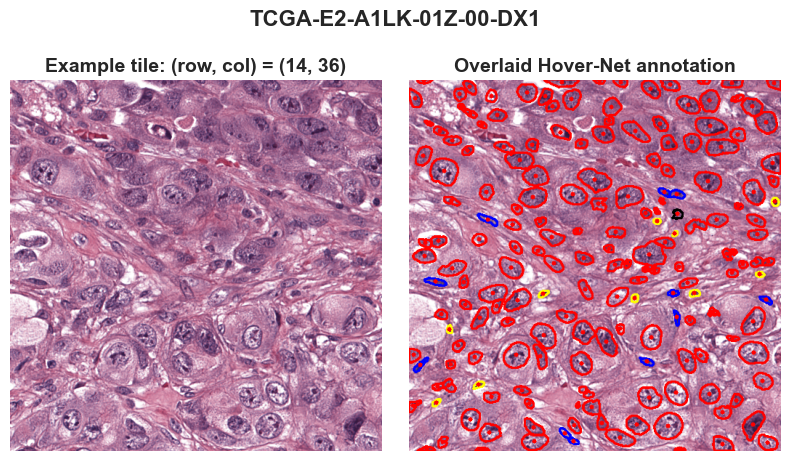

In [7]:
#%% plot tile & annotation images.

sns.set_style("white")
plt.rcParams.update({
    "xtick.major.size": 8, "xtick.major.width": 2, 
    "ytick.major.size": 8, "ytick.major.width": 2, 
    "xtick.bottom": True, "ytick.left": True, 
    "axes.spines.top": False, "axes.spines.right": False, 
    "axes.linewidth": 2, "axes.edgecolor": "#000000", 
    "grid.linewidth": 1, "grid.color": "#000000", "grid.alpha": 0.8, 
    "legend.frameon": False, "legend.edgecolor": "#000000", 
    "legend.framealpha": 0.9, "legend.markerscale": 1.2, 
    "font.family": "sans"})

colors   = ["#E08DAC", "#7595D0", "#75D0B0", "#B075D0", "#C3D075", 
            "#FFC72C", "#708090", "#A9A9A9", "#DFDFDF", "#000000"]

fontdict = {"label": {"size": 12, "weight": "regular"}, 
            "sbttl": {"size": 14, "weight": "bold"}, 
            "title": {"size": 16, "weight": "bold"}, 
            "super": {"size": 20, "weight": "bold"}, 
            "panel": {"size": 36, "weight": "bold"}}

titles   = [f"Example tile: (row, col) = {tile_coord}", 
            "Overlaid Hover-Net annotation"]

fig1, ax1 = plt.subplots(figsize = (8, 14), nrows = 1, ncols = 2)
for ax, im, ttl in zip(ax1, [tile_image, tile_annot], titles):
    ax.imshow(im);    ax.axis(False);
    ax.set_title(ttl, wrap = True, **fontdict["sbttl"]);
fig1.suptitle(slide_id, wrap = True, y = 0.67, **fontdict["title"]);

fig1.tight_layout(h_pad = 0, w_pad = 2)
plt.show()


In [8]:
#%% save data.

svdat = True
if svdat:
    out_path  = "../../plots/v3/"
    out_file  = f"{slide_id}_example_tile_annotation.pdf"
    out_param = {"dpi": 600, "transparent": True, "bbox_inches": "tight"}
    out_data  = copy(fig1)
    
    print("\n".join(["saving example tile...", f"slide = {slide_id}"]));    _dt = time()
    out_data.savefig(out_path + out_file, **out_param)
    print(out_file);    del out_data
    _dt = time() - _dt;    print(f"done! elapsed time = {format_time(_dt)}.")


saving example tile...
slide = TCGA-E2-A1LK-01Z-00-DX1
TCGA-E2-A1LK-01Z-00-DX1_example_tile_annotation.pdf
done! elapsed time = 2 sec.


In [9]:
#%% prepare data for downsampled slide image.

mag_selected   = 20
tile_size      = 512
disp_tile_size = ceil(tile_size / 16)

## read slide data.
slide   = openslide.OpenSlide(data_paths[1] + data_files[subtype][0])
mag_sld = float(slide.properties[openslide.PROPERTY_NAME_OBJECTIVE_POWER])

## gather downsample slide data.
tile_size_ds   = tile_size * round(mag_sld / mag_selected)
n_cols, n_rows = [ceil(x / tile_size_ds) for x in slide.level_dimensions[0]]
dwnsmpl_all    = round(tile_size_ds / disp_tile_size)

print("preparing slide display data...");    _dt = time()

slide_disp = np.full((n_rows * disp_tile_size, n_cols * disp_tile_size, 3), 
                     dtype = np.uint8, fill_value = 255)
for y, x in tqdm(product(*map(range, [n_rows, n_cols])), total = n_rows * n_cols):
    ## read tile.
    tile = slide.read_region(location = (x * tile_size_ds, y * tile_size_ds), 
                             size = (tile_size_ds, tile_size_ds), level = 0)
    tile = tile.convert(mode = "RGB")

    ## downsample tile.
    if tile.size == (tile_size_ds, tile_size_ds):
        tile = tile.resize(size = (tile_size, tile_size))               # analysis downsampling
        tile = tile.resize(size = (disp_tile_size, disp_tile_size))     # display downsampling
        
        ## save downsampled data.
        if (y, x) == tile_coord:    tile_ds = tile.copy()
        slide_disp[(y * disp_tile_size):((y + 1) * disp_tile_size), 
                   (x * disp_tile_size):((x + 1) * disp_tile_size), :] = np.array(tile)
        
_dt = time() - _dt;    print(f"done! elapsed time = {format_time(_dt)}.")

print(f"""
prepared downsampled slide image! 
subtype = {subtype}, slide-ID = {tile_info.slide_id[subtype]}
magnification = {mag_sld:,}, slide-size = {slide.level_dimensions[0]}
downsampling-level-for-display = {dwnsmpl_all:,}, downsampled-image-shape = {slide_disp.shape}
""")


preparing slide display data...


100%|███████████████████████████████████████████████████████████████| 9576/9576 [12:10<00:00, 13.11it/s]

done! elapsed time = 12 min 11 sec.

prepared downsampled slide image! 
subtype = TNBC, slide-ID = TCGA-E2-A1LK-01Z-00-DX1
magnification = 40.0, slide-size = (135183, 73105)
downsampling-level-for-display = 32, downsampled-image-shape = (2304, 4256, 3)



downsampled tile:


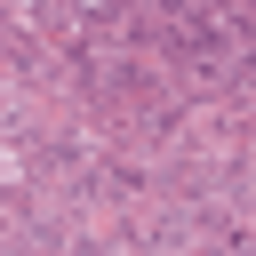

In [10]:
print("downsampled tile:")
tile_ds.resize(size = (256, 256))


In [11]:
#%% save data.
## save downsampled slide data w/o bounding box.

svdat = True
if svdat:
    out_path = "../../DataForFigure_V2/slide_data/"
    out_file = f"{slide_id}_downsampled_{dwnsmpl_all}.npy"
    out_data = slide_disp.copy()
    
    print("\n".join(["saving downsampled slide data...", 
                     f"slide = {slide_id}, downsampling-level = {dwnsmpl_all}"]))
    _dt = time()
    np.save(out_path + out_file, arr = out_data, allow_pickle = True)
    print(out_file);    del out_data
    _dt = time() - _dt;    print(f"done! elapsed time = {format_time(_dt)}.")


saving downsampled slide data...
slide = TCGA-E2-A1LK-01Z-00-DX1, downsampling-level = 32
TCGA-E2-A1LK-01Z-00-DX1_downsampled_32.npy
done! elapsed time = 1 sec.


In [12]:
#%% add bounding box to slide. 

box_color  = [0, 0, 240]                                    # bounding box color
line_color = [0, 240, 0]                                    # line color for tile division
draw_lines = True

## offset slide boundaries for better visual.
## [row-top, row-bottom, col-left, col-right]
# disp_offset = [0, 10, 0, 5]                                 # HER2+
# disp_offset = [0, 15, 0, 20]                                # HR+
disp_offset = [0, 20, 0, 30]                                # TNBC
if isinstance(disp_offset, (int, float)):
    disp_offset = [disp_offset] * 4
elif len(disp_offset) == 2:
    disp_offset = [disp_offset[0]] * 2 + [disp_offset[1]] * 2

slide_box_disp = slide_disp.copy()

## plot all lines.
if draw_lines:
    slide_box_disp[:, ::disp_tile_size, :] = line_color
    slide_box_disp[::disp_tile_size, :, :] = line_color

## horizontal boundary.
slide_box_disp[
    (tile_coord[0] - 0) * disp_tile_size, 
    ((tile_coord[1] - 0) * disp_tile_size):((tile_coord[1] + 1) * disp_tile_size):1, 
    :] = box_color
slide_box_disp[
    (tile_coord[0] + 1) * disp_tile_size, 
    ((tile_coord[1] - 0) * disp_tile_size):((tile_coord[1] + 1) * disp_tile_size):1, 
    :] = box_color

## vertical boundary.
slide_box_disp[
    ((tile_coord[0] - 0) * disp_tile_size):((tile_coord[0] + 1) * disp_tile_size):1, 
    (tile_coord[1] - 0) * disp_tile_size, 
    :] = box_color
slide_box_disp[
    ((tile_coord[0] - 0) * disp_tile_size):((tile_coord[0] + 1) * disp_tile_size):1, 
    (tile_coord[1] + 1) * disp_tile_size, 
    :] = box_color

## finalize image.
slide_box_disp = slide_box_disp[
    disp_offset[0]:-disp_offset[1], disp_offset[2]:-disp_offset[3]]

print(f"""
added bounding box to tile! coordinate: (row, col) = {tile_coord}
drawing lines for tile division: {draw_lines}
""")



added bounding box to tile! coordinate: (row, col) = (14, 36)
drawing lines for tile division: True



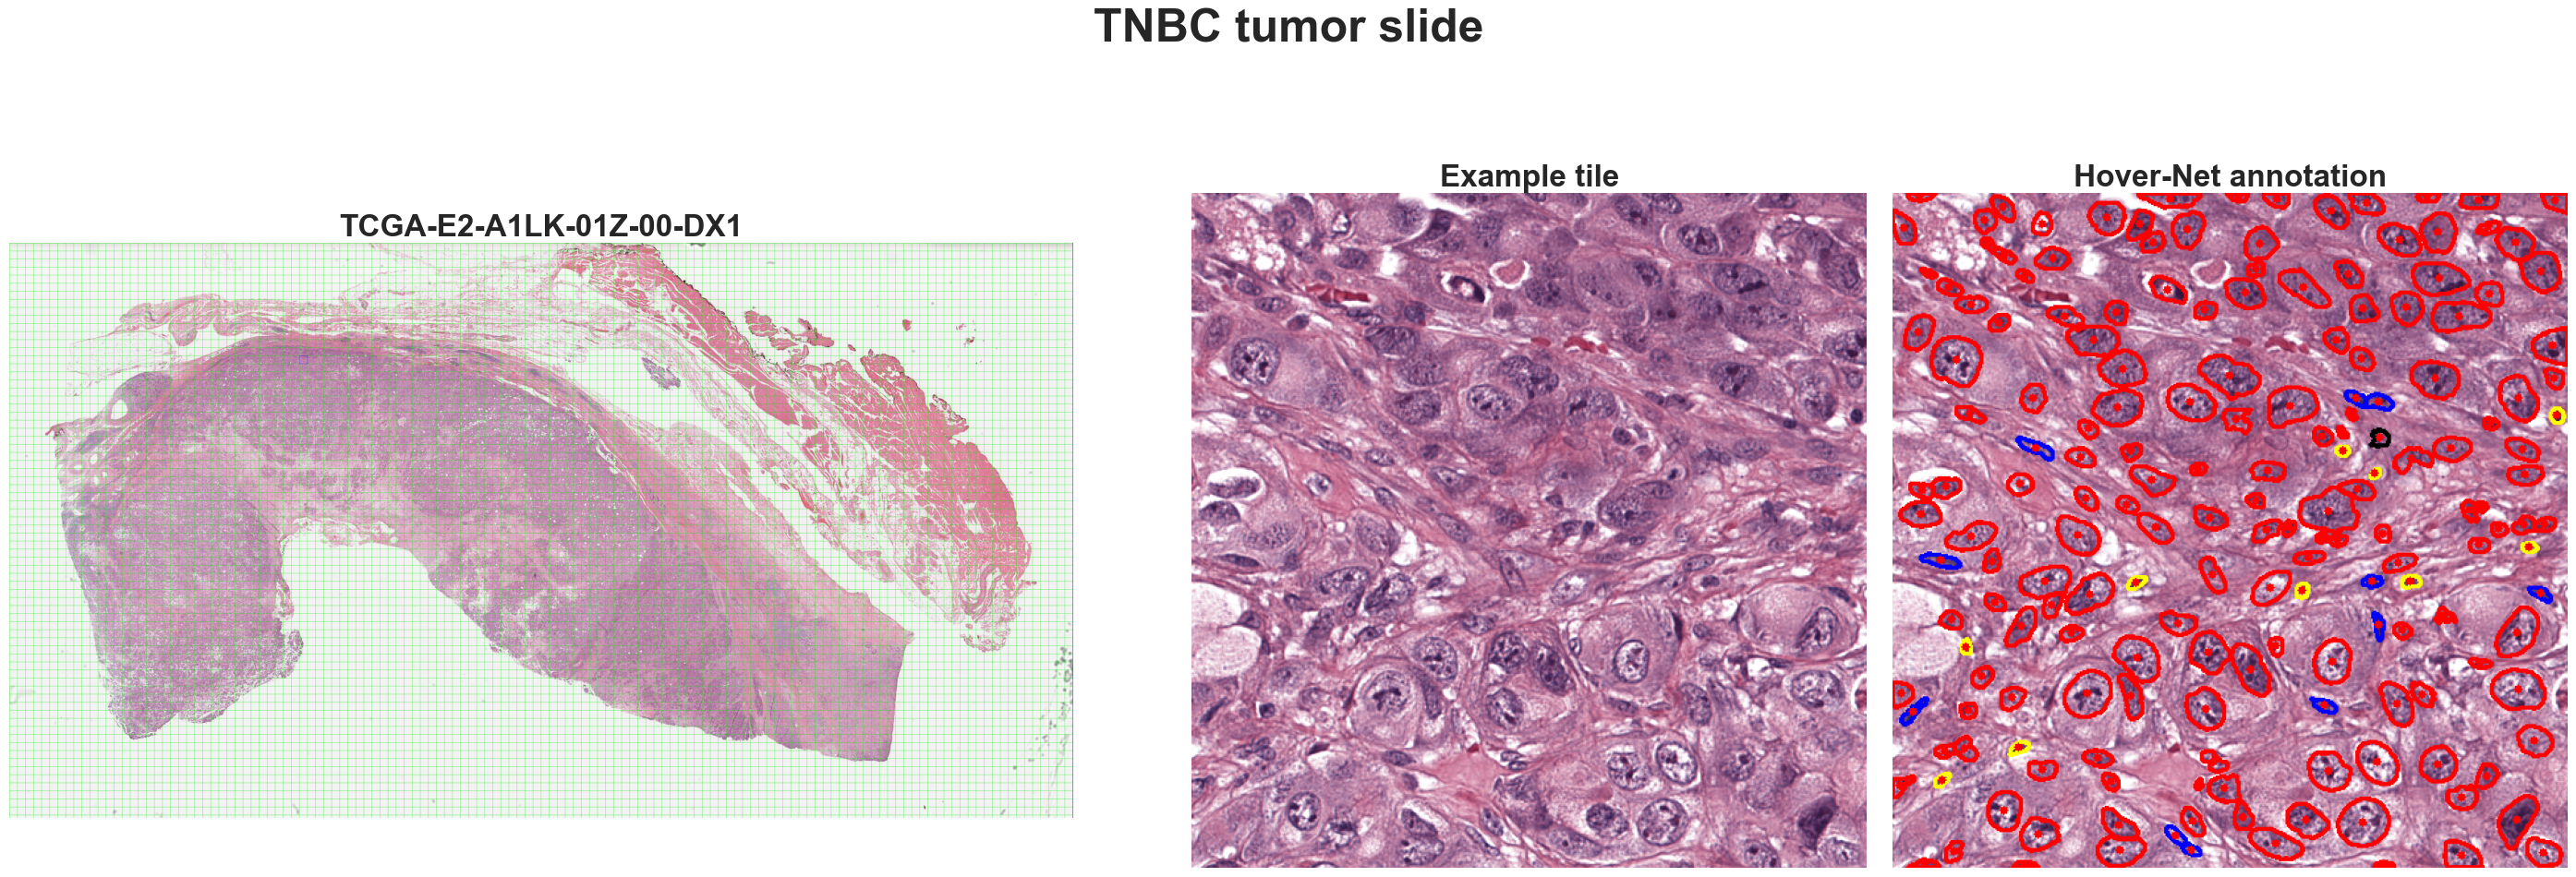

In [13]:
#%% plot slide, tile & annotations side-by-side.

sns.set_style("white")
plt.rcParams.update({
    "xtick.major.size": 8, "xtick.major.width": 2, 
    "ytick.major.size": 8, "ytick.major.width": 2, 
    "xtick.bottom": True, "ytick.left": True, 
    "axes.spines.top": False, "axes.spines.right": False, 
    "axes.linewidth": 2, "axes.edgecolor": "#000000", 
    "grid.linewidth": 1, "grid.color": "#000000", "grid.alpha": 0.8, 
    "legend.frameon": False, "legend.edgecolor": "#000000", 
    "legend.framealpha": 0.9, "legend.markerscale": 1.2, 
    "font.family": "sans"})

colors    = ["#E08DAC", "#7595D0", "#75D0B0", "#B075D0", "#C3D075", 
             "#FFC72C", "#708090", "#A9A9A9", "#DFDFDF", "#000000"]

fontdict  = {"label": {"size": 12, "weight": "regular"}, 
             "sbttl": {"size": 14, "weight": "bold"}, 
             "title": {"size": 16, "weight": "bold"}, 
             "super": {"size": 20, "weight": "bold"}, 
             "mega" : {"size": 24, "weight": "bold"}, 
             "panel": {"size": 36, "weight": "bold"}}

titles    = [slide_id, "Example tile", "Hover-Net annotation", f"{subtype} tumor slide"]

fig2, ax2 = plt.subplot_mosaic(
    mosaic = [["A", "A", "A", "e1", "e2", "e2"], ["A", "A", "A", "e1", "B", "C"], 
              ["A", "A", "A", "e1", "e3", "e3"]], figsize = (28, 16), 
    width_ratios = [0.5] * 3 + [0.1] + [1] * 2, height_ratios = [0.1, 1, 0.1])

for lbl, im, ttl in zip(list("ABC"), [slide_box_disp, tile_image, tile_annot], titles):
    ax = ax2[lbl];    ax.imshow(im);    ax.axis(False);
    ax.set_title(ttl, wrap = True, **fontdict["mega"]);

[fig2.delaxes(ax2[lbl]) for lbl in ["e1", "e2", "e3"]];                # delete empty plots
fig2.suptitle(titles[-1], wrap = True, y = 0.82, ha = "center", va = "center", ma = "center", 
              **fontdict["panel"]);

fig2.tight_layout(h_pad = 2, w_pad = 2)
plt.show()


In [14]:
#%% save data.

svdat = True
if svdat:
    out_path  = "../../plots/v3/"
    out_file  = f"{slide_id}_slide_tile_example_annotation.pdf"
    if draw_lines:    out_file = out_file.replace(".", "_v2.")
    out_param = {"dpi": 600, "transparent": True, "bbox_inches": "tight"}
    out_data  = copy(fig2)
    
    print("\n".join(["saving slide image + example tile/annotations...", 
                     f"slide = {slide_id}, downsampling-level = {dwnsmpl_all}"]))
    _dt = time()
    out_data.savefig(out_path + out_file, **out_param)
    print(out_file);    del out_data
    _dt = time() - _dt;    print(f"done! elapsed time = {format_time(_dt)}.")


saving slide image + example tile/annotations...
slide = TCGA-E2-A1LK-01Z-00-DX1, downsampling-level = 32
TCGA-E2-A1LK-01Z-00-DX1_slide_tile_example_annotation_v2.pdf
done! elapsed time = 18 sec.


In [15]:
""" tile examples for low-risk and high-risk patients """ 

data_path = "../../DataForFigure_V2/ForManuscriptExampleTiles/V3/Survival/"
subtypes  = ["HER2+", "HR+", "TNBC"]

data_files = {sb: [ ] for sb in subtypes}
for sb, grp in product(subtypes, ["LowRisk", "HighRisk"]):
    sld = listfiles(f"{data_path}{sb}/{grp}/")[0]
    ims = f"{data_path}{sb}/{grp}/{sld}/"
    data_files[sb] += [f"{sb}/{grp}/{sld}/{im}" for im in listfiles(ims)]

pd.DataFrame(
    data_files, 
    index = ["low_risk_tile", "low_risk_annot", "high_risk_tile", "high_risk_annot"])


HER2+  \
low_risk_tile            HER2+/LowRisk/TCGA-A2-A04X/tile_1060.png   
low_risk_annot   HER2+/LowRisk/TCGA-A2-A04X/tile_1060_overlay.png   
high_risk_tile           HER2+/HighRisk/TCGA-AC-A23H/tile_113.png   
high_risk_annot  HER2+/HighRisk/TCGA-AC-A23H/tile_113_overlay.png   

                                                             HR+  \
low_risk_tile              HR+/LowRisk/TCGA-C8-A273/tile_160.png   
low_risk_annot     HR+/LowRisk/TCGA-C8-A273/tile_160_overlay.png   
high_risk_tile           HR+/HighRisk/TCGA-BH-A1EX/tile_1595.png   
high_risk_annot  HR+/HighRisk/TCGA-BH-A1EX/tile_1595_overlay.png   

                                                             TNBC  
low_risk_tile              TNBC/LowRisk/TCGA-D8-A13Z/tile_122.png  
low_risk_annot     TNBC/LowRisk/TCGA-D8-A13Z/tile_122_overlay.png  
high_risk_tile           TNBC/HighRisk/TCGA-E2-A1LK/tile_1872.png  
high_risk_annot  TNBC/HighRisk/TCGA-E2-A1LK/tile_1872_overlay.png

In [16]:
#%% read all images.

images_all = {
    sb: [Image.open(data_path + file, mode = "r", formats = ["png"]) 
         for file in data_files[sb]] 
    for sb in subtypes}
images_all


{'HER2+': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>],
 'HR+': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>],
 'TNBC': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>]}

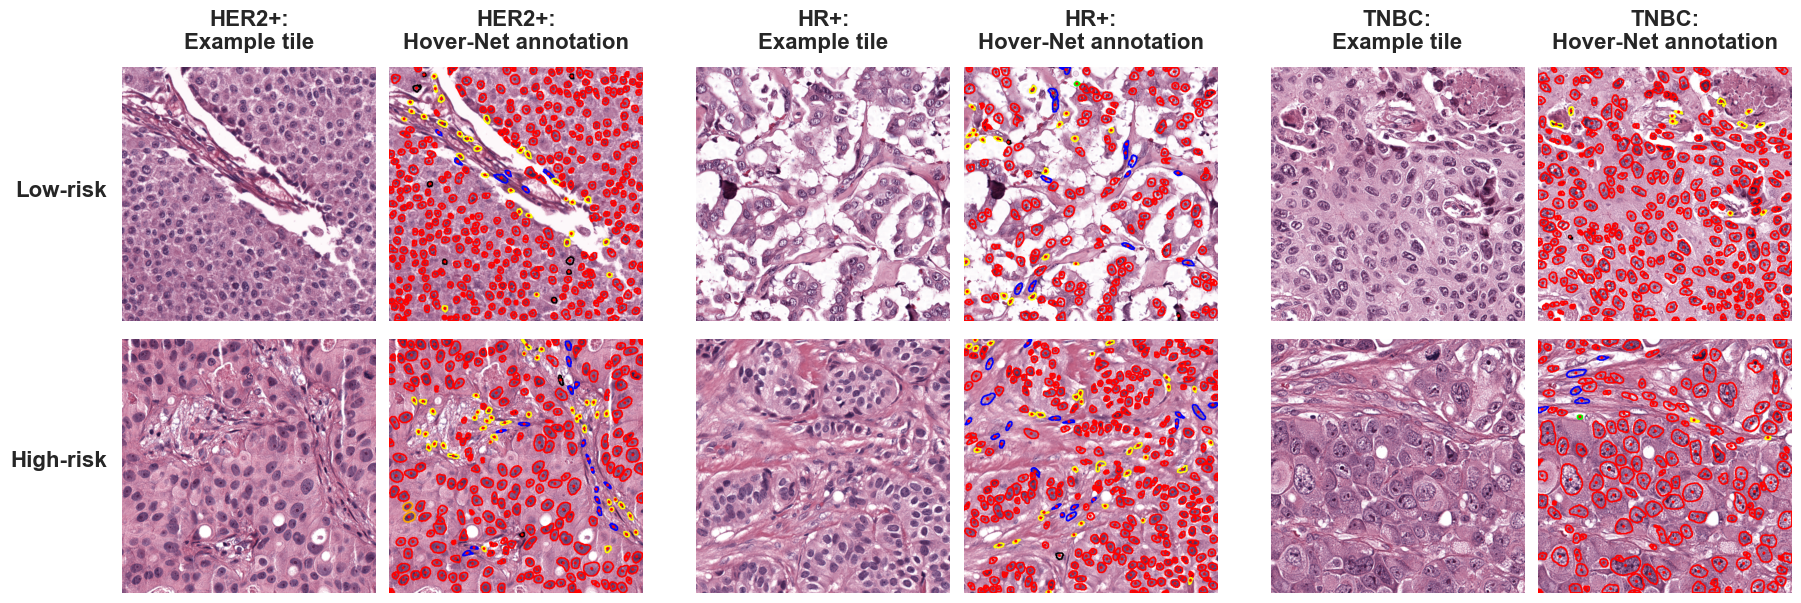

In [17]:
#%% plot tiles & annotations side-by-side for each subtype/risk group.

sns.set_style("white")
plt.rcParams.update({
    "xtick.major.size": 8, "xtick.major.width": 2, 
    "ytick.major.size": 8, "ytick.major.width": 2, 
    "xtick.bottom": True, "ytick.left": True, 
    "axes.spines.top": False, "axes.spines.right": False, 
    "axes.linewidth": 2, "axes.edgecolor": "#000000", 
    "grid.linewidth": 1, "grid.color": "#000000", "grid.alpha": 0.8, 
    "legend.frameon": False, "legend.edgecolor": "#000000", 
    "legend.framealpha": 0.9, "legend.markerscale": 1.2, 
    "font.family": "sans"})

colors    = ["#E08DAC", "#7595D0", "#75D0B0", "#B075D0", "#C3D075", 
             "#FFC72C", "#708090", "#A9A9A9", "#DFDFDF", "#000000"]

fontdict  = {"label": {"size": 12, "weight": "regular"}, 
             "sbttl": {"size": 14, "weight": "bold"}, 
             "title": {"size": 16, "weight": "bold"}, 
             "super": {"size": 20, "weight": "bold"}, 
             "mega" : {"size": 24, "weight": "bold"}, 
             "panel": {"size": 36, "weight": "bold"}}

lblprop   = {"rotation": 0, "ha": "right", "va": "center"}

fig3, ax3 = plt.subplot_mosaic(
    mosaic = [["A1", "A2", "e1", "B1", "B2", "e2", "C1", "C2"], 
              ["A3", "A4", "e1", "B3", "B4", "e2", "C3", "C4"]], figsize = (17, 6), 
    width_ratios = [1, 1, 0.1, 1, 1, 0.1, 1, 1], height_ratios = [1, 1])

for sb, lbl in zip(subtypes, list("ABC")):
    ttls = [f"{sb}:\nExample tile", f"{sb}:\nHover-Net annotation", None, None]
    for k, im in enumerate(images_all[sb], start = 1):
        ax = ax3[f"{lbl}{k}"];    ax.imshow(im);    ax.axis(False);
        ax.set_title(ttls[k-1], wrap = True, y = 1.05, **fontdict["title"]);

[fig3.delaxes(ax3[lbl]) for lbl in ["e1", "e2"]];                # delete empty plots
fig3.text(x = 0, y = 0.70, s = "Low-risk", **lblprop, **fontdict["title"]);
fig3.text(x = 0, y = 0.25, s = "High-risk", **lblprop, **fontdict["title"]);

fig3.tight_layout(w_pad = 1, h_pad = 1)
plt.show()


In [18]:
#%% save data.

svdat = True
if svdat:
    out_path  = "../../plots/v3/"
    out_file  = "TCGA_slide_tile_examples_annotations_risk_groups.pdf"
    out_param = {"dpi": 600, "transparent": True, "bbox_inches": "tight"}
    out_data  = copy(fig3)
    
    print("saving slide example tiles/annotations for risk groups...")
    _dt = time()
    out_data.savefig(out_path + out_file, **out_param)
    print(out_file);    del out_data
    _dt = time() - _dt;    print(f"done! elapsed time = {format_time(_dt)}.")


saving slide example tiles/annotations for risk groups...
TCGA_slide_tile_examples_annotations_risk_groups.pdf
done! elapsed time = 22 sec.
